# Univariate Analysis

The objective of this notebook is to analyze each variable separately to understand its distribution, central tendencies (mean, median), and dispersion (variance, standard deviation). It also includes visualization of variables.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import pie_plot, qq_plots, skewness_and_kurtosis, detect_outliers
import numpy as np
import os
from IPython.display import Image
from scipy.stats import probplot, shapiro, kstest, normaltest, anderson

if not os.path.exists('images_univar_analysis'):
    os.makedirs('images_univar_analysis')

In [2]:
data = pd.read_parquet('../data/processed/df_fraud.parquet', engine='fastparquet')
data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,no_fraud
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,no_fraud
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,fraud
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,fraud
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,no_fraud


In [3]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype   
---  ------          --------------    -----   
 0   step            6362620 non-null  int16   
 1   type            6362620 non-null  category
 2   amount          6362620 non-null  float32 
 3   nameOrig        6362620 non-null  category
 4   oldbalanceOrig  6362620 non-null  float32 
 5   newbalanceOrig  6362620 non-null  float32 
 6   nameDest        6362620 non-null  category
 7   oldbalanceDest  6362620 non-null  float32 
 8   newbalanceDest  6362620 non-null  float32 
 9   isFraud         6362620 non-null  category
dtypes: category(4), float32(5), int16(1)
memory usage: 263.4 MB


# Visualization of the target variable

## isFraud

In [4]:
data['isFraud'].describe(include = ['O'])

count      6362620
unique           2
top       no_fraud
freq       6354407
Name: isFraud, dtype: object

In [5]:
data['isFraud'].value_counts()

isFraud
no_fraud    6354407
fraud          8213
Name: count, dtype: int64

In [6]:
data['isFraud'].value_counts(normalize=True).mul(100).apply(lambda x: f'{x:.3f}%')

isFraud
no_fraud    99.871%
fraud        0.129%
Name: proportion, dtype: object

Observations: 

The vast majority of transactions are non-fraudulent, which is evidenced by the vast amount of no_fraud records (99.871%). This is typical in fraud datasets, where fraudulent instances are much less common compared to non-fraudulent instances.

# Visualization of the categorical variables

## Type

In [7]:
data['type'].describe(include = ['O'])

count      6362620
unique           5
top       CASH_OUT
freq       2237500
Name: type, dtype: object

In [8]:
data['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

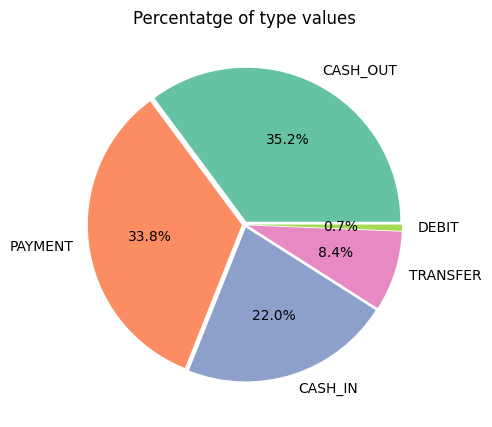

In [9]:
pie_plot(data['type'])

Observations: 
- CASH_OUT & PAYMENT are the predominant types of transactions
- CASH_IN & TRANSFER are relatively popular
- DEBIT is the less common among types of transactions. 



## nameOrig and nameDest

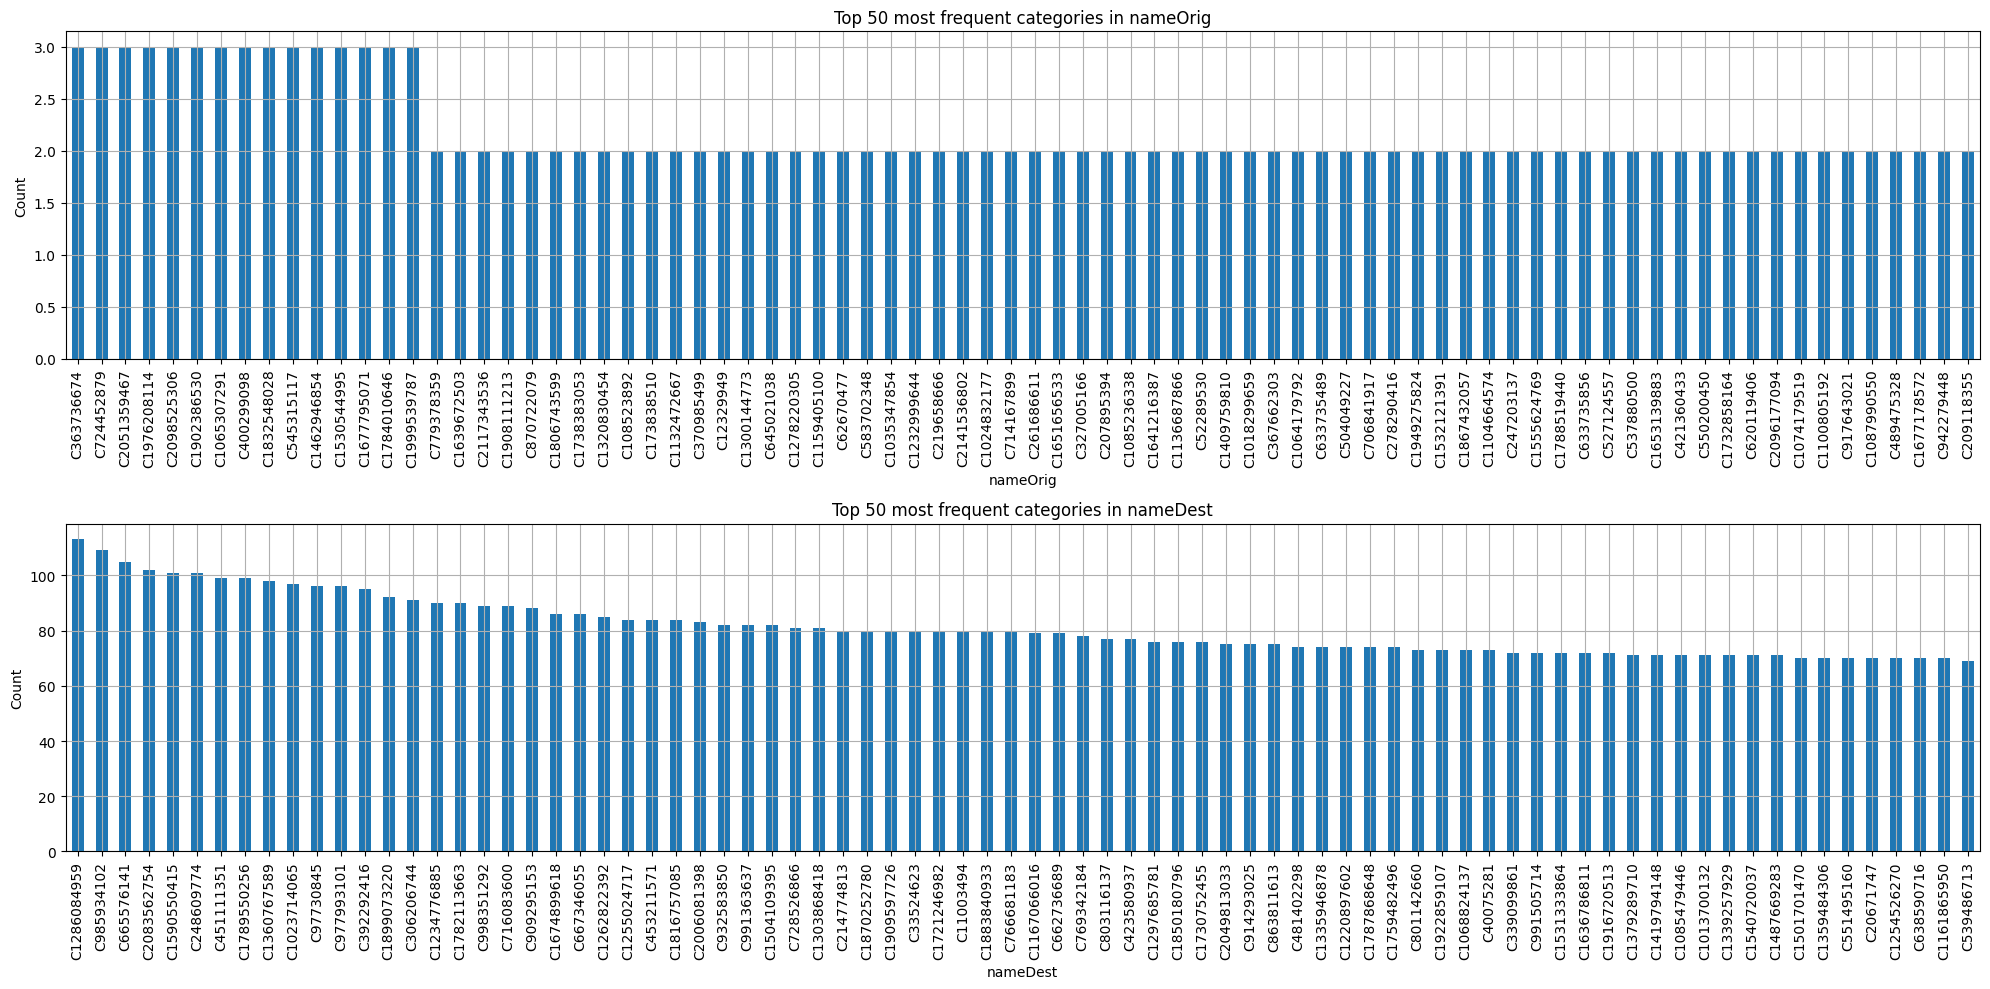

In [10]:

categorical_cols = [ 'nameOrig', 'nameDest']

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

for ax, col in zip(axs, categorical_cols):
    top_categories = data[col].value_counts().nlargest(80)
    
    top_categories.plot(kind='bar', ax=ax)
    
    ax.set_title(f'Top 50 most frequent categories in {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.grid(True)

plt.tight_layout()
plt.show()

Observations:
- nameOrig: some accounts have sent money more than 1 time. The maximum of times are 2 or 3. Is there a relationship between fraudulent behaviours and the amount of times the account has sent money?

- nameDest: many accounts have sent money more several times. The account with most transactions reaches almost 110 transactions. It's going to be interesting to analyse if in this case the accounts with high frequency of usage have some relationship with the fraudulent behaviours too. 

# Visualization of the numerical variables

### Basic overview of the distributions for all numerical variables

In [11]:
numeric_cols = data.select_dtypes(include=['int16', 'float32']).columns.tolist()

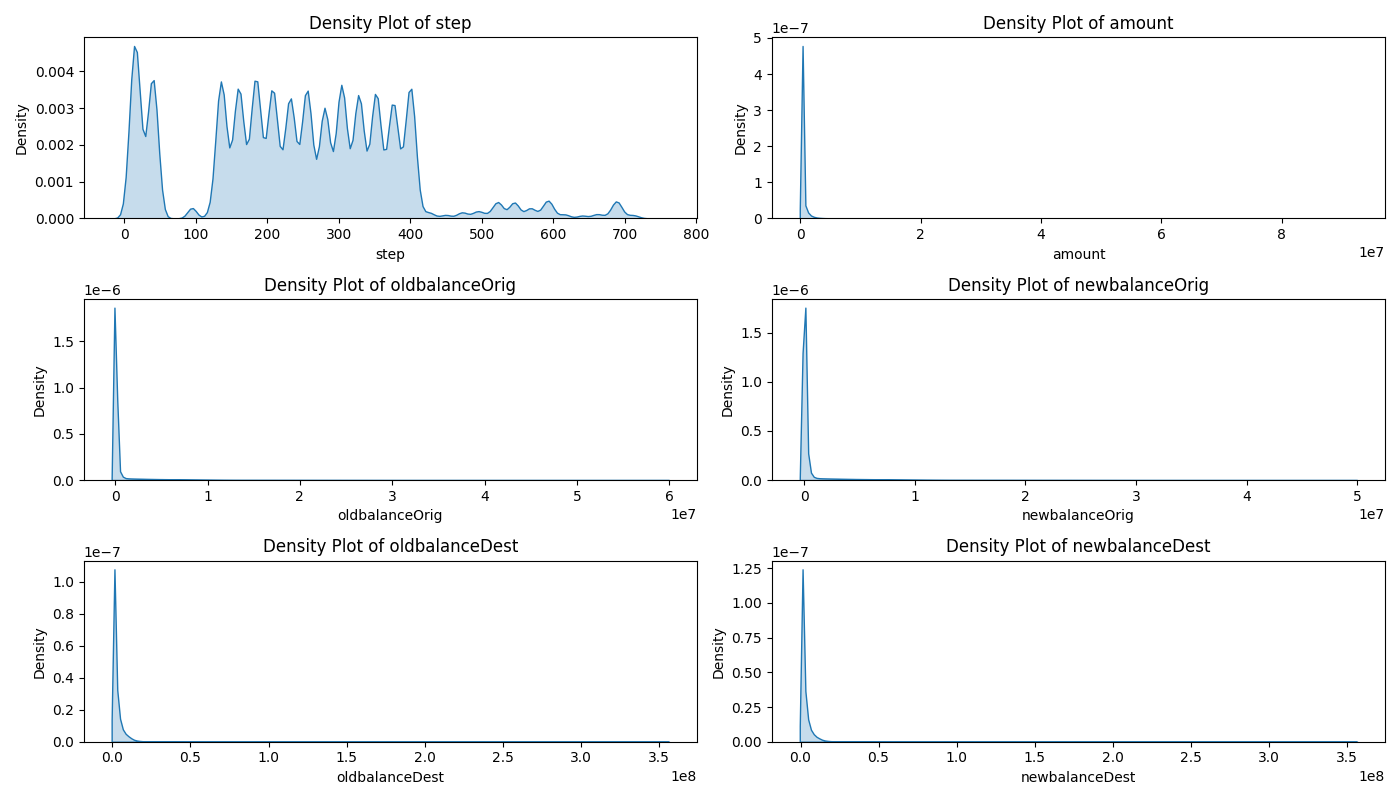

In [12]:
plot_filename = 'images_univar_analysis/numerical_density_plots.png'

if not os.path.isfile(plot_filename):
        
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))
    axes = axes.flatten()
    
    for ax, col in zip(axes, numeric_cols):
        sns.kdeplot(data[col], ax=ax, fill=True)
        ax.set_title(f'Density Plot of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Density')
    
    plt.tight_layout()
    plt.savefig(plot_filename)  
    plt.close(fig)  

Image(filename=plot_filename)

Observations:

- The column 'step' has two ranges that look interesting and will be checked later more accurately.

- The columns oldbalanceOrig, newbalanceOrig have many values in 0 or very close to 0 (part of the plot is negative) this is also shown in the statistics where the medians are low or even 0.

- The columns 'amount', 'oldbalanceDest','newbalanceDest' have most of the values slighty above 0.



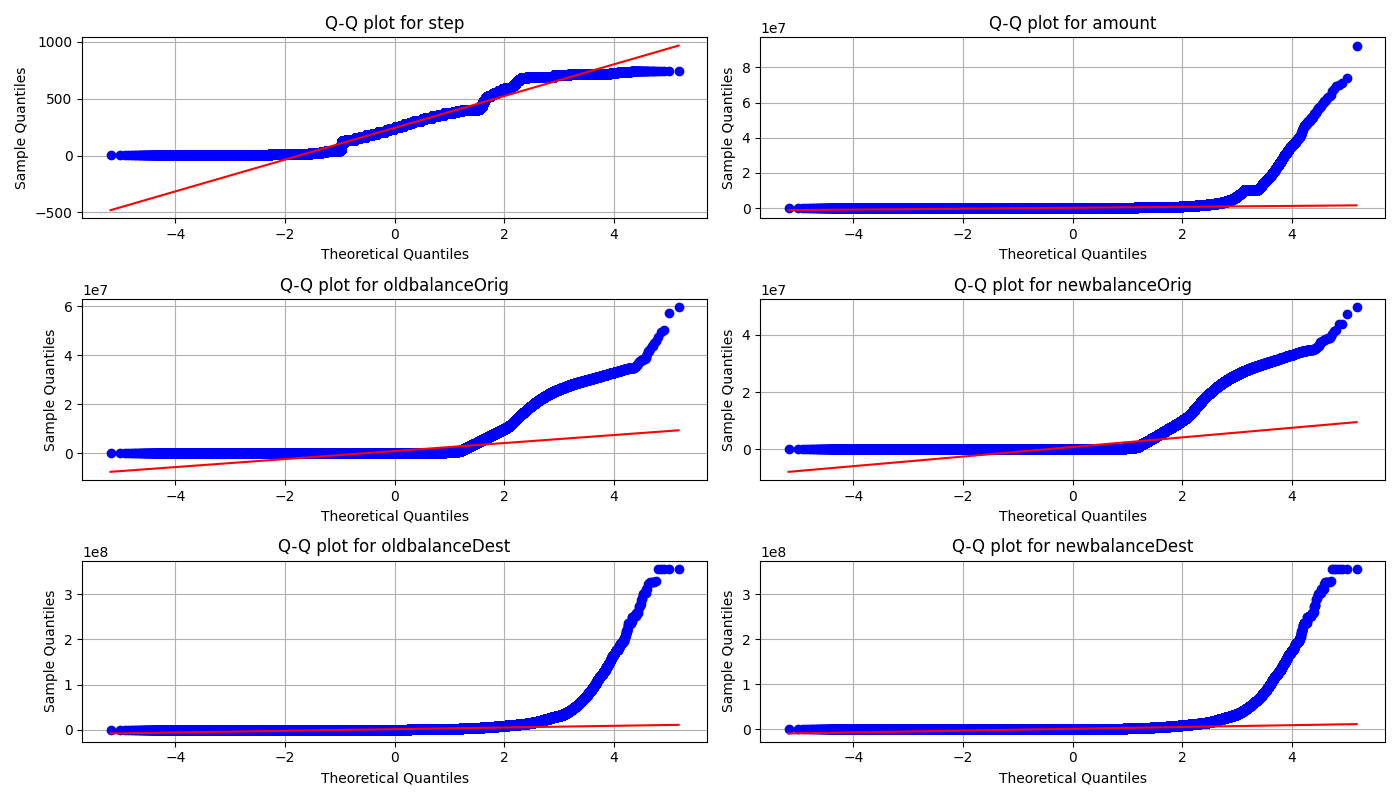

In [13]:
plot_filename = 'images_univar_analysis/numerical_qq_plots.png'

if not os.path.isfile(plot_filename):
    num_plots = len(numeric_cols)
    num_cols = 2
    num_rows = (num_plots // num_cols) + (num_plots % num_cols)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(14, 8))
    axes = axes.flatten()

    for ax, col in zip(axes, numeric_cols):
        probplot(data[col], dist="norm", plot=ax)
        ax.set_title(f'Q-Q plot for {col}')
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Sample Quantiles')
        ax.grid(True)

    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig(plot_filename)  
    plt.close(fig)  

Image(filename=plot_filename)

Observations:

- In the variable 'step' the points fall along a line in the middle of the graph, but curve off in the extremities, this behavior means that the data has more extreme values than would be expected if they truly came from a normal distribution.

- Positive skewness in the rest of the columns. 



### Step

In [14]:
data['step'].describe()

count    6.362620e+06
mean     2.433972e+02
std      1.423320e+02
min      1.000000e+00
25%      1.560000e+02
50%      2.390000e+02
75%      3.350000e+02
max      7.430000e+02
Name: step, dtype: float64

Observations:
- The mean (243.40) and median (239.00) are close, indicating relatively symmetric distribution. However, the standard deviation (142.33) suggests considerable variability in the data.

- The wide range (from 1 to 743) and the large difference between the 25th percentile (156) and the 75th percentile (335) suggest that there are high values or outliers in the dataset. This indicates potential right skewness.

Since I have many rows, I'm going to use a density plot for better visualization 

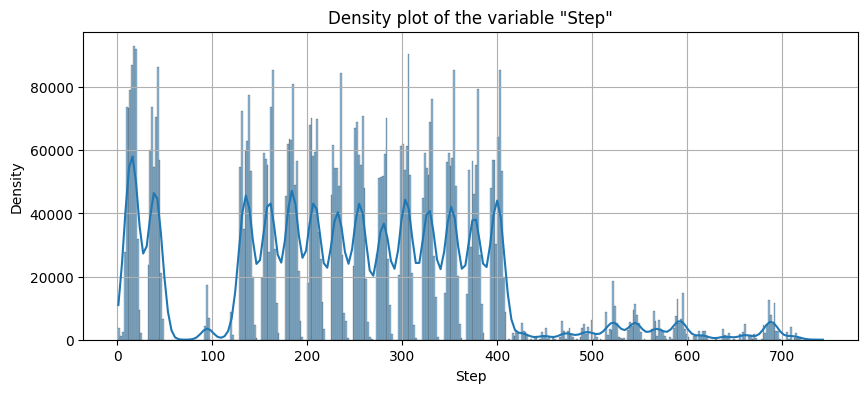

In [15]:
plt.figure(figsize=(10, 4))
sns.histplot(data['step'], kde=True)
plt.title('Density plot of the variable "Step"')
plt.xlabel('Step')
plt.ylabel('Density')
plt.grid()
plt.show()

The are two main step ranges where the amount of transactions are very likely to happen. 

- Are they related to fraudulent behavior? 
- How is the behavior divided per day instead?

In [16]:
skewness_and_kurtosis(data, 'step')

{'skewness': 0.37517688846984765, 'kurtosis': 0.3290705550254467}

Observations: 

For context, 1 step represents 1 hour. The total range of hour data is equivalent to a month. 

- Skewness is close to 0, good, but the distribution is not normal. 
- Kurtosis is ver low (Platykurtic) but the distribution is not normal.

Even though these results say the distribution can be considered normal, the distribution plot doesn't say the same.  

---
Time to check the normality:
- Shapiro-Wilk Test? 
No, if N > 5000, computed p-value may not be accurate. My current N = 6362620.

- Let's go with the Kolmogorov-Smirnov Test & the D'Agostino and Pearson's Test


In [17]:
kstest_test = kstest(data['step'], 'norm')
print('Kolmogorov-Smirnov Test: Statistics=%.3f, p=%.3f' % (kstest_test.statistic, kstest_test.pvalue))

Kolmogorov-Smirnov Test: Statistics=0.999, p=0.000


In [18]:
dagostino_test = normaltest(data['step'])
print('D\'Agostino and Pearson\'s Test: Statistics=%.3f, p=%.3f' % (dagostino_test.statistic, dagostino_test.pvalue))

D'Agostino and Pearson's Test: Statistics=161119.511, p=0.000


None of the p-values are high enough to label the our distribution as a normal distribution. Further analysis can be done here, I just wanted to make clear that when results are weird we have to dig a bit deeper.

---

Time to check the distribution per day

In [19]:
data['day_of_month'] = np.ceil(data['step'] / 24).astype('int')
data['day_of_month'] = data['day_of_month'].astype('category')

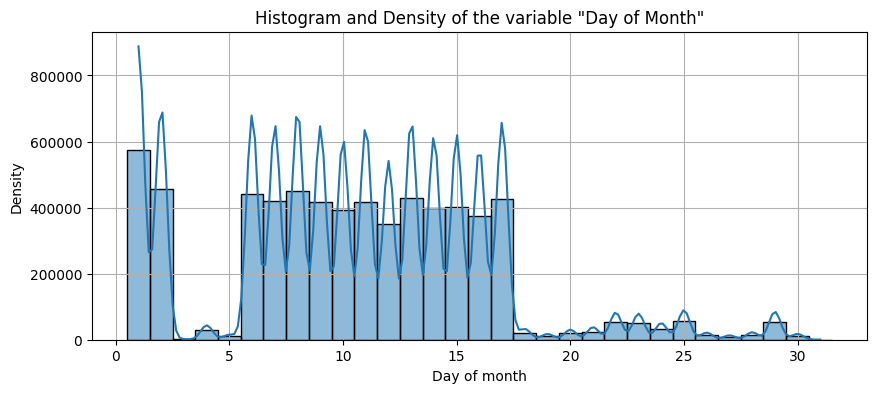

In [20]:
plt.figure(figsize=(10, 4))
sns.histplot(data['day_of_month'], kde=True)
plt.title('Histogram and Density of the variable "Day of Month"')
plt.xlabel('Day of month')
plt.ylabel('Density')
plt.grid()
plt.show()

Observations: 

The interpretation of the plot is easier when using days and it follows the same distribution. There are two main groups:

- Group 1: customers use the first and second day to do transactions. It makes sense since people get paid at the end of the month so they can use their money in the first days. 

- Group 2: customers use the app from day 6 to day 17 to do transactions. That doesn't make sense to me. At this point I would try to get some information the dataset i.e. the month of the year that we are analysing... is pre-Christmas time? Maybe Easter? From there I should decide what to do with this extraordinary (or not) customer behavior.

In [21]:
skewness_and_kurtosis(data, 'day_of_month')

TypeError: 'Categorical' with dtype category does not support reduction 'skew'

Observations:

The new variable based on days slightly increases both skewness and kurtosis but the distribution still doesn't become normal.

### Amount

In [ ]:
data['amount'].describe()

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

Observations:

- The mean (179.861,90) is significantly higher than the median (74.871,94), which, along with a high standard deviation (603.858,22), indicates that the distribution is heavily skewed to the right with a large number of high-value outliers.

- The minimum value is 0 and the maximum is 92.445.200, suggesting a wide range of values. The 25th percentile (13.389,57) and 75th percentile (208.721,50) show that the upper range of values contributes significantly to the high mean, further indicating right-skewness and potential outliers.

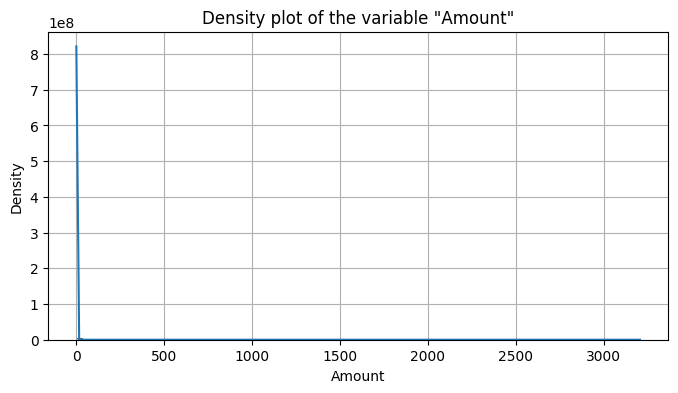

In [ ]:
count = data['amount'].value_counts()

plt.figure(figsize=(8, 4))
sns.histplot(count, kde=True, bins = 100)
plt.title('Density plot of the variable "Amount"')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.grid()
plt.show()

I see nothing here, let's zoom in the small values 

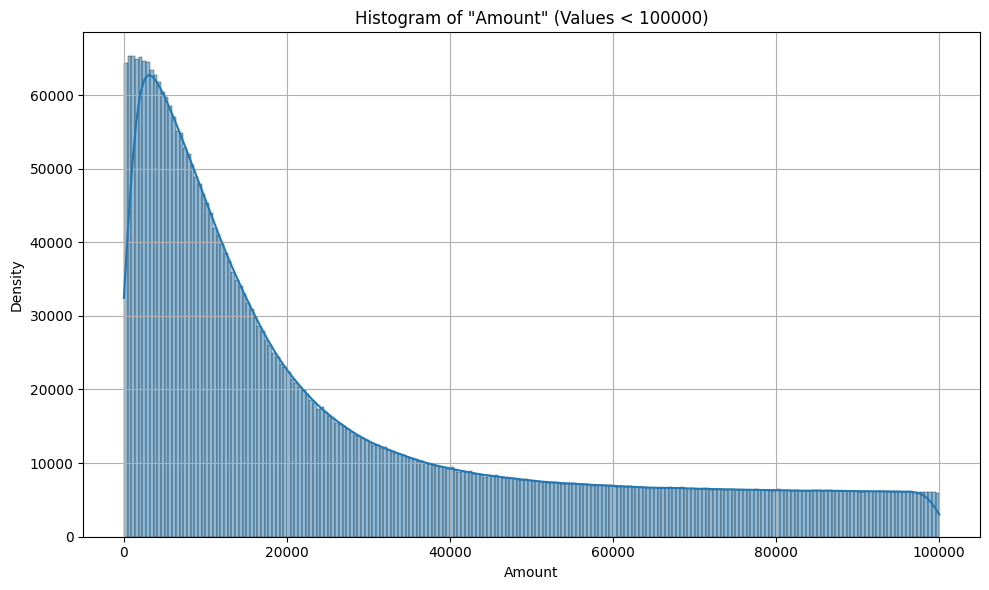

In [ ]:
plt.figure(figsize=(10, 6))


sns.histplot(data[data['amount'] < 100000]['amount'], kde=True)
plt.title('Histogram of "Amount" (Values < 100000)')
plt.xlabel('Amount')
plt.ylabel('Density')

plt.tight_layout()
plt.grid()
plt.show()


In [ ]:
skewness_and_kurtosis(data, 'amount')

{'skewness': 30.993926834170814, 'kurtosis': 1797.9546160061514}

Observations:

Here we can see the distribution shape that reflect the basic statitstical data from above. Most transactions are below 40.000€. The distribution is very skewed and leptokurtic but we have to take this last result with a grain of salt since the distribution is not normal.

- Are this type of small amount transactions related to fraudulent behaviour?

----

I'm going to check if there are any amounts repeatedly used in transfers

In [ ]:
count_amounts = data['amount'].value_counts()
count_amounts

amount
1.000000e+07    3207
1.000000e+04      88
5.000000e+03      79
1.500000e+04      68
5.000000e+02      65
                ... 
1.755922e+05       1
3.501580e+04       1
3.053856e+04       1
2.432749e+05       1
1.752871e+05       1
Name: count, Length: 5236933, dtype: int64

In [ ]:
repeated_amounts = count_amounts[count_amounts > 1]
repeated_amounts

amount
1.000000e+07    3207
1.000000e+04      88
5.000000e+03      79
1.500000e+04      68
5.000000e+02      65
                ... 
1.629713e+05       2
1.494518e+04       2
3.790100e+02       2
2.586672e+04       2
8.434885e+04       2
Name: count, Length: 851681, dtype: int64

In [ ]:
integers = repeated_amounts[repeated_amounts.index % 1 == 0]
print(f'The length of the amounts with integers is: {len(integers)}')
integers.head(20)

The length of the amounts with integers is: 9850


amount
10000000.0    3207
10000.0         88
5000.0          79
15000.0         68
500.0           65
100000.0        42
21500.0         37
120000.0        29
135000.0        20
0.0             16
8661.0           9
1837.0           7
4168.0           7
5011.0           7
3779.0           7
2089.0           7
621.0            6
3345.0           6
5988.0           6
408.0            6
Name: count, dtype: int64

In [ ]:
non_integers = repeated_amounts[repeated_amounts.index % 1 != 0]
print(f'The length of the old balances with decimals is: {len(non_integers)}')
non_integers.head(20)

The length of the old balances with decimals is: 841831


amount
10180.179688    9
2431.379883     9
2152.260010     9
4546.069824     9
5047.669922     9
3748.949951     9
213.860001      9
1711.670044     9
4648.120117     9
2704.300049     8
6257.729980     8
4105.209961     8
783.710022      8
4611.529785     8
3246.110107     8
6650.060059     8
8226.400391     8
765.460022      8
1692.800049     8
2511.620117     8
Name: count, dtype: int64

Observations: 

- Some repeated amounts with integers  and very specific numbers are much more frequent than amounts with decimals. Is it a coincidence? Humans try to use integers and rounded numbers rather than random amounts with decimals. Can we infer a fraudulent behavior from those balances?

- There are amounts of 0€. What is the explanation for that? Is it maybe an error? Maybe fraudsters are trying to get money? Are those related to the type of transaction? 

---

I'm going to use exponential increasing bins since the range of my data is high and I also think that exponential bins can reflect sectors of population better when it comes to purchasing power. Further analysis can give some insights using uniform bins.

In [ ]:
bins = [0, 1000, 10000, 100000, 1000000, 10000000, 100000000]
labels = ['0-1.000', '1.000-10.000', '10.000-100.000', '100.000-1.000.000', '1.000.000-10.000.000', '10.000.000-100.000.000']
data['amount_range'] = pd.cut(data['amount'], bins=bins, labels=labels, right=False)
data['amount_range'] = data['amount_range'].astype('category')

In [ ]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,amount_range
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,no_fraud,1.000-10.000
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,no_fraud,1.000-10.000
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,fraud,0-1.000
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,fraud,0-1.000
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,no_fraud,10.000-100.000


In [ ]:
data['amount_range'].value_counts()

amount_range
100.000-1.000.000         2706738
10.000-100.000            2239253
1.000-10.000              1143361
0-1.000                    142642
1.000.000-10.000.000       124976
10.000.000-100.000.000       5650
Name: count, dtype: int64

In [ ]:
data['amount_range'].describe()

count               6362620
unique                    6
top       100.000-1.000.000
freq                2706738
Name: amount_range, dtype: object

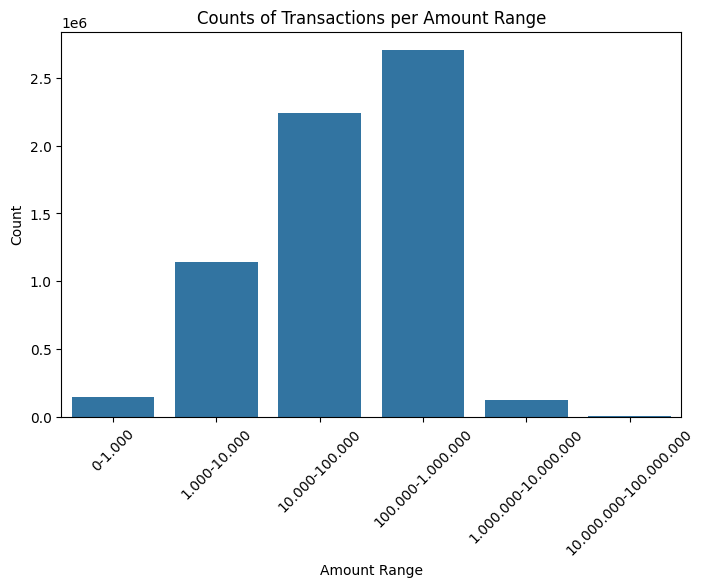

In [ ]:
order = ['0-1.000', '1.000-10.000', '10.000-100.000', '100.000-1.000.000', '1.000.000-10.000.000', '10.000.000-100.000.000']


plt.figure(figsize=(8, 5))
barplot = sns.countplot(data=data, x='amount_range', order=order)

plt.title('Counts of Transactions per Amount Range')
plt.xlabel('Amount Range')
plt.ylabel('Count')

plt.xticks(rotation=45)  
plt.show()

Observations:

- The most commonn ranges are 10.000 - 100.000 and 100.000 - 1.000.000.
- The bins approach looks good to me even though other non exponential bin strategies could be considered. 
- I will study if this approach provides some insights about the relationship with fraudulent behaviours.

## oldbalanceOrig 

In [ ]:
data['oldbalanceOrig'].describe()

count    6.362620e+06
mean     8.338834e+05
std      2.888242e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.420800e+04
75%      1.073152e+05
max      5.958504e+07
Name: oldbalanceOrig, dtype: float64

Observations:

- The mean of the dataset is 833.883,1, which is significantly higher than the median of 14.208. This discrepancy suggests that the data is right-skewed. The spread of the data is considerable, as indicated by the standard deviation of 2.888.242.

- The range of the data goes from 0 to 59.585.040 (again significant variability). The middle half of the data is also spread out, though not as extensively as the entire range.

In [ ]:
old_orig = data['oldbalanceOrig'].value_counts()
old_orig.head(10)

oldbalanceOrig
0.0      2102449
184.0        918
133.0        914
195.0        912
164.0        909
109.0        908
181.0        908
157.0        902
146.0        899
136.0        898
Name: count, dtype: int64

Observations:

- Many repeated balances of 0€. We should compare them with other variables since making transactions when you have 0€ in the bank is a bit risky unless you have some credit.
- It calls my attention that the most frequent transactions are integers.

---

Let's check the repeated balances

In [ ]:
filtered_old_orig = old_orig[old_orig >1]

In [ ]:
# pd.set_option('display.max_rows', None) 
filtered_old_orig

oldbalanceOrig
0.000000e+00    2102449
1.840000e+02        918
1.330000e+02        914
1.950000e+02        912
1.640000e+02        909
                 ...   
2.533250e+05          2
7.135600e+02          2
1.756390e+05          2
4.564456e+06          2
2.021050e+05          2
Name: count, Length: 216307, dtype: int64

Observations:

There are 90 unique balances that are repeated and those repeated are actually repeated many times. That's weird right? And are they all integers?

In [ ]:
integers = filtered_old_orig[filtered_old_orig.index % 1 == 0]
print(f'The length of the old balances with integers is: {len(integers)}')
integers.head()

The length of the old balances with integers is: 198526


oldbalanceOrig
0.0      2102449
184.0        918
133.0        914
195.0        912
164.0        909
Name: count, dtype: int64

In [ ]:
non_integers = filtered_old_orig[filtered_old_orig.index % 1 != 0]
print(f'The length of the old balances with decimals is: {len(non_integers)}')
non_integers.head(20)

The length of the old balances with decimals is: 17781


oldbalanceOrig
1.165188e+06    4
3.790633e+04    4
1.839251e+04    4
5.141607e+04    4
4.910404e+06    4
1.802813e+04    4
4.292574e+05    4
1.119173e+04    3
6.606673e+04    3
2.211678e+05    3
5.212500e+03    3
9.400114e+04    3
1.396726e+06    3
3.716881e+06    3
5.669100e+02    3
1.172796e+05    3
5.243410e+03    3
2.632401e+05    3
1.891320e+03    3
1.465011e+06    3
Name: count, dtype: int64

Observations:

Ok, my observation was wrong. There are repeated balances with decimals. 

Anyways the frequency of the top balances with integers and decimals differs a lot and relatively small balances are much more repeated than high balances. This last behavior makes sense since small transactions are always more frequent than bigger transactions but further analysis can be done to understand the whole distribution of balances related to their frequency and amount.

In [ ]:
skewness_and_kurtosis(data,'oldbalanceOrig')

{'skewness': 5.2491364, 'kurtosis': 32.964874}

Observations:

- There are repeated old balances over time. I have divided them into amounts of integers and amounts with decimals.

- There are many transactions with old balance = 0€. How is this possible? We should compare the type of transaction to check what if they are related. 



- High skewness and kurtosis

## newbalanceOrig

In [ ]:
data['newbalanceOrig'].describe()

Observations:

- The mean is quite high (855,113.7), but the median is 0. This suggests that while the average balance is relatively high, a large proportion of records have a balance of 0. This indicates a right-skewed distribution with a significant number of zero or near-zero balances.

- The standard deviation is very high (2,924,049), indicating a high level of variability in the data. This large dispersion suggests that there are some very high balances compared to the majority. The range of 49,585,040 indicates that the balances vary widely, from 0 to nearly 50 million, highlighting the presence of extreme values. The quartiles further confirm that a large portion of the data has low balances (including zero), with a smaller proportion having higher balances.

In [ ]:
new_orig = data['newbalanceOrig'].value_counts()
new_orig.head(10)

In [ ]:
filtered_new_orig = new_orig[new_orig >1]
filtered_new_orig.head(10)

In [ ]:
len(filtered_new_orig)

In [ ]:
integers = filtered_new_orig[filtered_new_orig.index % 1 == 0]
print(f'The length of the new balances with integers is: {len(integers)}')
integers.head()

In [ ]:
non_integers = filtered_new_orig[filtered_new_orig.index % 1 != 0]
print(f'The length of the new balances with decimals is: {len(non_integers)}')
non_integers.head(20)

In [ ]:
skewness_and_kurtosis(data,'newbalanceOrig')

Observations:

- High skewness and kurtosis

## oldbalanceDest

In [ ]:
data['oldbalanceDest'].describe()

- The mean value of 1,100,702 is significantly higher than the median value of 132,705.7. This suggests that the distribution is positively skewed, meaning that there are some extremely high values (outliers) pulling the mean up.


- The standard deviation is very high (3,399,180), indicating a large variability around the mean. This is consistent with the large difference between the mean and median, as well as the large range. The range of 356,015,900 shows a wide spread between the minimum and maximum values.The fact that both the 25th percentile and the median are much lower than the 75th percentile and maximum reinforces the idea of a right-skewed distribution, with a large proportion of low to mid-range values and a few very high values.

In [ ]:
old_dest = data['oldbalanceDest'].value_counts()
old_dest.head(20)

In [ ]:
filtered_old_dest = old_dest[old_dest >1]
filtered_old_dest.head()

In [ ]:
integers = filtered_old_dest[filtered_old_dest.index % 1 == 0]
print(f'The length of the old balances with integers is: {len(integers)}')
integers.head(20)

In [ ]:
non_integers = filtered_old_dest[filtered_old_dest.index % 1 != 0]
print(f'The length of the old balances with decimals is: {len(non_integers)}')
non_integers.head(20)

In [ ]:
skewness_and_kurtosis(data,'newbalanceOrig')

Observations:

- High skewness and kurtosis

## newbalanceDest

In [ ]:
data['newbalanceDest'].describe()

Observations:

- The mean and median values suggest a central tendency around a substantial amount. The mean (1,224,996) is higher than the median (214,661.4), indicating that while a substantial portion of the balances are around the median, the mean is significantly influenced by some very high balances. The large standard deviation (3,674,129) compared to the mean indicates high variability in the data. The spread of values is considerable, which is consistent with the maximum value being over 356 million.


- Both the 25th and 50th percentiles being at 0.0 and 214,661.4, respectively, highlight that while many entries are zero or low, there are also significant balances that push the mean higher. The 75th percentile value (1,111,909) shows that a substantial portion of the data has balances that are quite high compared to the median. The very high maximum value (356,179,300) indicates the presence of some extreme outliers. These extreme high values skew the mean upwards and contribute to the large standard deviation.

In [ ]:
new_dest = data['newbalanceDest'].value_counts()
new_dest.head(10)

In [ ]:
filtered_new_dest = new_dest[new_dest >1]

In [ ]:
integers = filtered_new_dest[filtered_new_dest.index % 1 == 0]
print(f'The length of the new balances with integers is: {len(integers)}')
integers.head(20)

In [ ]:
non_integers = filtered_new_dest[filtered_new_dest.index % 1 != 0]
print(f'The length of the new balances with decimals is: {len(non_integers)}')
non_integers.head(20)

In [ ]:
skewness_and_kurtosis(data,'newbalanceDest')

Observations:

It catches my attention the amount of exact same amounts of money moved. Maybe it's a coincidence but needs further analysis.

- Very high skewness and kurtosis.

## Outliers

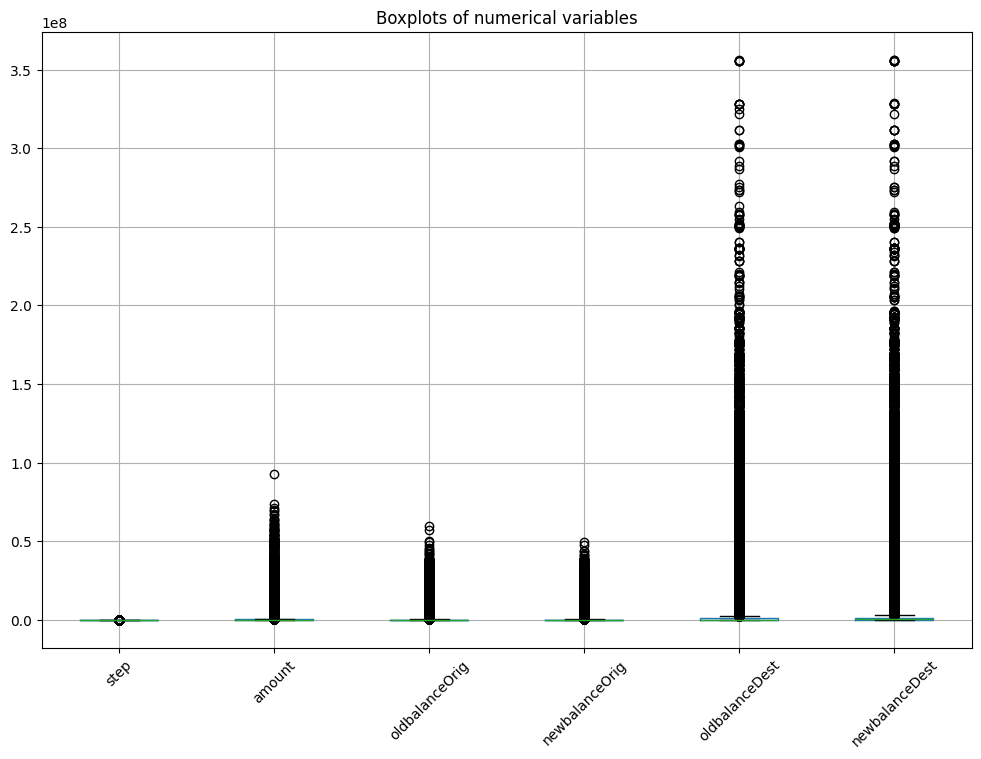

In [ ]:
numeric_cols = data.select_dtypes(include=['int16','float32'])

plt.figure(figsize=(12, 8))
numeric_cols.boxplot()
plt.title('Boxplots of numerical variables')
plt.xticks(rotation=45)
plt.show()

In [ ]:
detect_outliers(data)

Column: step, Percentage of outliers: 1.61%, Total number of outliers: 102688
Column: amount, Percentage of outliers: 5.31%, Total number of outliers: 338078
Column: oldbalanceOrig, Percentage of outliers: 17.49%, Total number of outliers: 1112507
Column: newbalanceOrig, Percentage of outliers: 16.56%, Total number of outliers: 1053391
Column: oldbalanceDest, Percentage of outliers: 12.36%, Total number of outliers: 786135
Column: newbalanceDest, Percentage of outliers: 11.61%, Total number of outliers: 738527


In [ ]:
# Función para identificar outliers usando el método IQR
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)].index

In [ ]:
# Identificar outliers en cada columna
outliers_indices = {}
columns_to_check = ['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

for column in columns_to_check:
    outliers_indices[column] = identify_outliers(data, column)
    print(f"Column: {column}, Total number of outliers: {len(outliers_indices[column])}")



Column: step, Total number of outliers: 102688
Column: amount, Total number of outliers: 338078
Column: oldbalanceOrig, Total number of outliers: 1112507
Column: newbalanceOrig, Total number of outliers: 1053391
Column: oldbalanceDest, Total number of outliers: 786135
Column: newbalanceDest, Total number of outliers: 738527


In [ ]:
# Opción 2: Reemplazar outliers con la mediana
df_imputed_outliers = data.copy()
for column in columns_to_check:
    median = data[column].median()
    df_imputed_outliers.loc[outliers_indices[column], column] = median

In [ ]:
df_imputed_outliers.to_parquet('../data/processed/df_fraud_univar.parquet', engine= 'fastparquet')